# Tutorial 4: A two-asset HANK model

In this notebook we solve the two-asset HANK model from Auclert, Bardóczy, Rognlie, Straub (2021): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models" ([link to paper](https://www.bencebardoczy.com/publication/sequence-jacobian/sequence-jacobian.pdf)).

For more examples and information on the SSJ toolkit, please visit their [GitHub page](https://github.com/shade-econ/sequence-jacobian).

We consolodate all code into one cell to get to the modifications/extensions as quickly as possible

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules

## 1 Model description

The household problem is characterized by the Bellman equation
$$
\begin{align} \tag{1}
V_t(e, b_{-}, a_{-}) = \max_{c, b, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} + \beta \mathbb{E}_t V_{t+1}(e', b, a) \right\}
\\
c + a + b &= z_t(e) + (1 + r_t^a)a_{-} + (1 + r_t^b)b_{-} - \Psi(a, a_{-}) 
\\
a &\geq \underline{a}, \quad b \geq \underline{b},
\end{align}
$$

where $z_t(e)$ is labor income and the adjustment cost function is specified as

$$
\Psi(a, a_{-}) =  \frac{\chi_1}{\chi_2}\left|\frac{a - (1 + r_t^a) a_{-}}{(1 + r_{t}^a) a_{-} + \chi_0}\right|^{\chi_2} \left[(1 + r_t^a) a_{-} + \chi_0 \right],
$$

with $\chi_0, \chi_1 > 0$ and $\chi_2 > 1.$ For the full description of the model, including the problems of the other agents, please see appendix B.3 of the paper.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
import sequence_jacobian.examples.two_asset as m
from sequence_jacobian.classes import FactoredJacobianDict

@solved(unknowns={'pi': (-0.1, 0.1)}, targets=['nkpc'], solver="brentq")
def pricing_solved(pi, mc, r, Y, kappap, mup):
    nkpc = kappap * (mc - 1/mup) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / \
           (1 + r(+1)) - (1 + pi).apply(np.log)
    return nkpc

@solved(unknowns={'p': (5, 15)}, targets=['equity'], solver="brentq")
def arbitrage_solved(div, p, r):
    equity = div(+1) + p(+1) - p * (1 + r(+1))
    return equity

@simple
def labor(Y, w, K, Z, alpha):
    N = (Y / Z / K(-1) ** alpha) ** (1 / (1 - alpha))
    mc = w * N / (1 - alpha) / Y
    return N, mc


@simple
def investment(Q, K, r, N, mc, Z, delta, epsI, alpha):
    inv = (K / K(-1) - 1) / (delta * epsI) + 1 - Q
    val = alpha * Z(+1) * (N(+1) / K) ** (1 - alpha) * mc(+1) -\
        (K(+1) / K - (1 - delta) + (K(+1) / K - 1) ** 2 / (2 * delta * epsI)) +\
        K(+1) / K * Q(+1) - (1 + r(+1)) * Q
    return inv, val


production = combine([labor, investment])                              # create combined block
production_solved = production.solved(unknowns={'Q': 1., 'K': 10.},    # turn it into solved block
                                      targets=['inv', 'val'],
                                      solver='broyden_custom')

def make_grids(amin,bmin, bmax, amax, kmax, nB, nA, nK, nZ, rho_z, sigma_z):
    b_grid = grids.agrid(amin=bmin, amax=bmax, n=nB)
    a_grid = grids.agrid(amin=amin,amax=amax, n=nA)
    k_grid = grids.agrid(amax=kmax, n=nK)[::-1].copy()
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_z, sigma=sigma_z, N=nZ)
    return b_grid, a_grid, k_grid, e_grid, Pi

def income(e_grid, tax, w, N):
    z_grid = (1 - tax) * w * N * e_grid
    return z_grid


hh = hetblocks.hh_twoasset.hh
hh_ext = hh.add_hetinputs([income, make_grids])


blocks = [hh_ext, production_solved, pricing_solved, arbitrage_solved,
          m.dividend, m.taylor, m.fiscal, m.share_value,
          m.finance, m.wage, m.union, m.mkt_clearing]

hank = create_model(blocks, name='Two-Asset HANK')


blocks_ss = [hh_ext, m.partial_ss, m.union_ss,
             m.dividend, m.taylor, m.fiscal, m.share_value, m.finance, m.mkt_clearing]

hank_ss = create_model(blocks_ss, name='Two-Asset HANK SS')



calibration = {'Y': 1., 'N': 1.0, 'K': 10., 'r': 0.0125, 'rstar': 0.0125, 'tot_wealth': 14,
               'delta': 0.02, 'pi': 0., 'kappap': 0.1, 'muw': 1.1, 'Bh': 1.04, 'Bg': 2.8,
               'G': 0.2, 'eis': 0.5, 'frisch': 1., 'chi0': 0.25, 'chi2': 2, 'epsI': 4,
               'omega': 0.005, 'kappaw': 0.1, 'phi': 1.5, 'nZ': 3, 'nB': 50, 'nA': 70, 'nK': 50,
               'amin':0,'bmin':-2.28, 'bmax': 50, 'amax': 4000, 'kmax': 1, 'rho_z': 0.966, 'sigma_z': 0.92}

unknowns_ss = {'beta': 0.976, 'chi1': 6.5}
targets_ss = {'asset_mkt': 0., 'B': 'Bh'}

cali = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='broyden_custom')

ss =  hank.steady_state(cali)

exogenous = ['rstar', 'Z', 'G']
unknowns = ['r', 'w', 'Y']
targets = ['asset_mkt', 'fisher', 'wnkpc']
T = 300

J_ha = hh_ext.jacobian(ss, inputs=['N', 'r', 'ra', 'rb', 'tax', 'w'], T=T)



H_U = hank.jacobian(ss, unknowns, targets, T=T, Js={'hh': J_ha})
H_U_factored = FactoredJacobianDict(H_U, T)

G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T, Js={'hh': J_ha}, H_U_factored=H_U_factored)

calibration = {'Y': 1., 'N': 1.0, 'K': 10., 'r': 0.0125, 'rstar': 0.0125, 'tot_wealth': 14,
               'delta': 0.02, 'pi': 0., 'kappap': 0.1, 'muw': 1.1, 'Bh': 1.04, 'Bg': 2.8,
               'G': 0.2, 'eis': 0.5, 'frisch': 1., 'chi0': 0.25, 'chi2': 2, 'epsI': 4,
               'omega': 0.005, 'kappaw': 0.1, 'phi': 1.5, 'nZ': 3, 'nB': 50, 'nA': 70, 'nK': 50,
               'amin':0,'bmin':0, 'bmax': 50, 'amax': 4000, 'kmax': 1, 'rho_z': 0.966, 'sigma_z': 0.92}

cali = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='broyden_custom')

ssc =  hank.steady_state(cali)

J_ha = hh_ext.jacobian(ssc, inputs=['N', 'r', 'ra', 'rb', 'tax', 'w'], T=T)

H_U = hank.jacobian(ssc, unknowns, targets, T=T, Js={'hh': J_ha})
H_U_factored = FactoredJacobianDict(H_U, T)

GG = hank.solve_jacobian(ssc, unknowns, targets, exogenous, T=T, Js={'hh': J_ha}, H_U_factored=H_U_factored)


# Modifications

First, it's advised you read the modified_hank notebook in the same folder before reading further.

One thing to notice right off the bat is that this structure is highly sensitive. Trying to allow for borrowing in the illiquid asset completely breaks the model. We can incorporate borrowing into the liquid asset, but it's also sensitive -- moving the borrowing constraint a fraction of an inch from where it is now breaks everything, as does increasing the number of grid points to 100. Will have to look into more how much of this is a function of the aggregate asset supply constraints. An extension I am working on is adding a 3rd asset, a floating money supply (return zero), which the financial intermediary cannot invest in. Combining this with a cap of 0 on the "B" asset, it would provide a nice diichotomy of credit vs. reserves, with a possible extension to the extension being that households don't need to pay back everything with interest the next period so long as they don't hit the borrowing limit. 

Now let's do the same graphs as before 

For comparison, we will show the graphs without borrowing (allowed) followed by the graphs with borrowing 

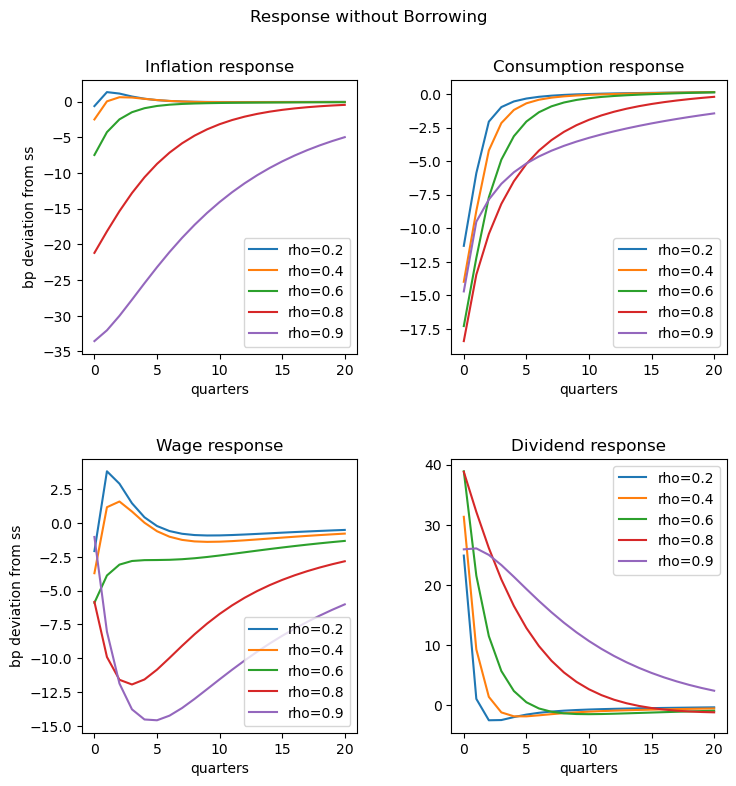

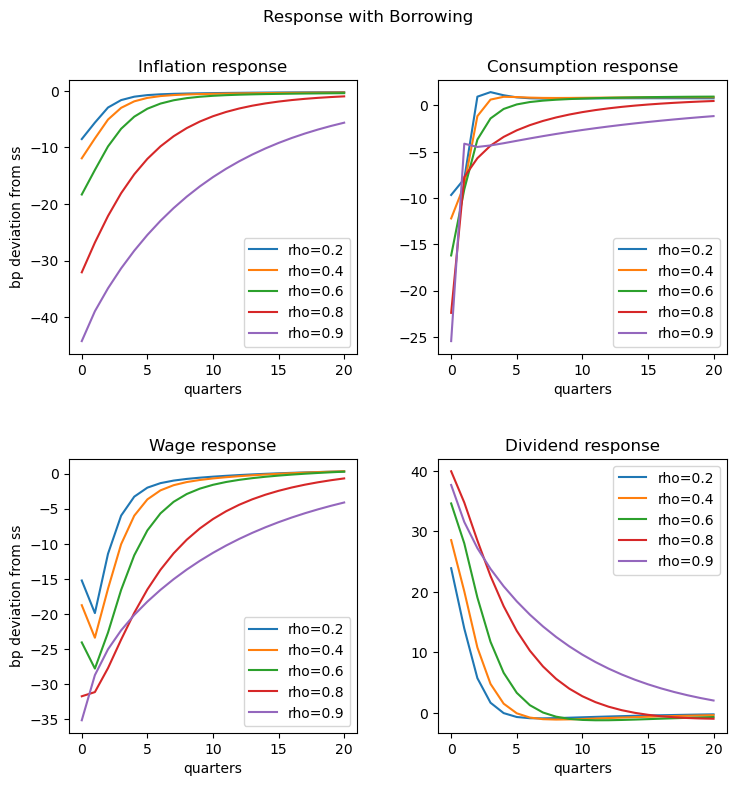

In [18]:
import matplotlib.pyplot as plt
import numpy as np

rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])

drstar = 0.0025 * rhos ** (np.arange(T)[:, np.newaxis])


dpi = 10000 * GG['pi']['rstar'] @ drstar
dci = 10000 * GG['C']['rstar'] @ drstar
ddi = 10000 * GG['div']['rstar'] @ drstar
dwi = 10000 * GG['w']['rstar'] @ drstar

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

for rho_value in rhos:
    index = rhos.tolist().index(rho_value)
    ax1.plot(dpi[:21, index], label=f'rho={rho_value}')
    ax2.plot(dci[:21, index], label=f'rho={rho_value}')
    ax3.plot(dwi[:21, index], label=f'rho={rho_value}')
    ax4.plot(ddi[:21, index], label=f'rho={rho_value}')

ax1.set_title(r'Inflation response')
ax1.set_xlabel('quarters')
ax1.set_ylabel('bp deviation from ss')
ax1.legend()

ax2.set_title('Consumption response')
ax2.set_xlabel('quarters')
ax2.legend()

ax3.set_title(r'Wage response')
ax3.set_xlabel('quarters')
ax3.set_ylabel('bp deviation from ss')
ax3.legend()

ax4.set_title('Dividend response')
ax4.set_xlabel('quarters')
ax4.legend()

plt.tight_layout(pad=3.0)
plt.suptitle("Response without Borrowing", y=1.01)
plt.show()

dpi = 10000 * G['pi']['rstar'] @ drstar
dci = 10000 * G['C']['rstar'] @ drstar
ddi = 10000 * G['div']['rstar'] @ drstar
dwi = 10000 * G['w']['rstar'] @ drstar

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

for rho_value in rhos:
    index = rhos.tolist().index(rho_value)
    ax1.plot(dpi[:21, index], label=f'rho={rho_value}')
    ax2.plot(dci[:21, index], label=f'rho={rho_value}')
    ax3.plot(dwi[:21, index], label=f'rho={rho_value}')
    ax4.plot(ddi[:21, index], label=f'rho={rho_value}')

ax1.set_title(r'Inflation response')
ax1.set_xlabel('quarters')
ax1.set_ylabel('bp deviation from ss')
ax1.legend()

ax2.set_title('Consumption response')
ax2.set_xlabel('quarters')
ax2.legend()

ax3.set_title(r'Wage response')
ax3.set_xlabel('quarters')
ax3.set_ylabel('bp deviation from ss')
ax3.legend()

ax4.set_title('Dividend response')
ax4.set_xlabel('quarters')
ax4.legend()

plt.tight_layout(pad=3.0)
plt.suptitle("Response with Borrowing", y=1.01)
plt.show()

For more transitory shocks, allowing for borrowing makes a _massive_ difference. An interest rate hike has essentially the same results as the base interest rate cut case, exhibiting a "Neo-Fisherian" property that can be observed in a vanilla NK model. Interesting. Otherwise, the analysis is virtually unchanged from the one asset case. Though note--this soirt of occurrence (huge differences in borrowing vs no borrowing world) wasn't present in the one asset model. 

In [ ]:
rho_r, sig_r = 0.61, 0.01/4
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}
Erstar_shock_path = {"rstar": -sig_r * rho_r ** (np.arange(T))}

td_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock_path,internals=['hh'])
Etd_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, Erstar_shock_path,internals=['hh'])

Because of the sensitivity to borrow, we can't do the exact same analysis as before because the number of gridpoints is not quite evenly spaced. We'll have to scale them. Also, we obviously have more assets to deal with. First, let's look at at people who now hold more of _both_ asserts. 

Note: as in the first notebook, the tables themselves are looking purely at gridpoint frequencies, that is the volume of gridpoints (in this case, combinations of liquid and illiquid asset holdings) where the policy function for (both) assets increase following an interest rate shock. Again, it's not possible here to borrow in the illiquid asset, so the 1st and 2nd columns are looking at holdings in the liquid asset at steady state. 

In [70]:
# 'a' internals -- change in policy function for someone at a given point in asset grid 
# 'Dbeg' ss0 -- probability distribution of agents at asset grid at steady state 
pop= ((td_nonlin.internals['hh']['a'][0][:,:,:] >= 0) & 
      (td_nonlin.internals['hh']['b'][0][:,:,:] >= 0) ).astype(int)
alta = ((Etd_nonlin.internals['hh']['a'][0][:,:,:] >= 0) & 
      (Etd_nonlin.internals['hh']['b'][0][:,:,:] >= 0) ).astype(int)
results = {}
s1 = 25/23
s2 = 25/27 
for j in range(3):
    sums_j = np.sum(pop[j, :,:])
    bors = np.sum(pop[j, :23,:])
    savs = sums_j - bors
    cum_freq = 100 * sums_j / np.sum(pop)
    st= s1*bors+s2*savs 
    borrower_percent = s1*100 * bors / st if sums_j != 0 else 0  
    savers_percent = s2*100 * savs / st if sums_j != 0 else 0  
    
    results[j] = {
        'Borrower %': borrower_percent,
        'Savers %': savers_percent,
        'Cum Freq': cum_freq
    }

print("Interest Rate HIKE: ", f"{round(100*np.sum(ss.internals['hh']['Dbeg'] * pop, axis=(0, 1,2)),1)}%", "save more than they would have")
print(" j | Borrower %    | Savers %     | Cum Freq")
print("-------------------------------------------------")
for j, data in results.items():
    bor_percent = f"{data['Borrower %']:.2f}%".rjust(12)
    sav_percent = f"{data['Savers %']:.2f}%".rjust(12)
    cum_freq = f"{data['Cum Freq']:.2f}%".rjust(10)
    print(f"{str(j).rjust(2)} | {bor_percent} | {sav_percent} | {cum_freq}")
print("-------------------------------------------")
print("\n")
for j in range(3):
    sums_j = np.sum(alta[j, :,:])
    bors = np.sum(alta[j, :23,:])
    savs = sums_j - bors
    cum_freq = 100 * sums_j / np.sum(alta)
    st= s1*bors+s2*savs
    borrower_percent = s1*100 * bors / st if sums_j != 0 else 0  
    savers_percent = s2*100 * savs / st if sums_j != 0 else 0  
    
    results[j] = {
        'Borrower %': borrower_percent,
        'Savers %': savers_percent,
        'Cum Freq': cum_freq
    }
print(" Interest Rate CUT: ", f"{round(100*np.sum(ss.internals['hh']['Dbeg'] * alta, axis=(0, 1,2)),1)}%", "save more than they would have")
print(" j | Borrower %    | Savers %     | Cum Freq")
print("-------------------------------------------------")
for j, data in results.items():
    bor_percent = f"{data['Borrower %']:.2f}%".rjust(12)
    sav_percent = f"{data['Savers %']:.2f}%".rjust(12)
    cum_freq = f"{data['Cum Freq']:.2f}%".rjust(10)
    print(f"{str(j).rjust(2)} | {bor_percent} | {sav_percent} | {cum_freq}")

Interest Rate HIKE:  14.5% save more than they would have
 j | Borrower %    | Savers %     | Cum Freq
-------------------------------------------------
 0 |       10.18% |       89.82% |     41.45%
 1 |       11.78% |       88.22% |     35.24%
 2 |       15.19% |       84.81% |     23.31%
-------------------------------------------


 Interest Rate CUT:  5.0% save more than they would have
 j | Borrower %    | Savers %     | Cum Freq
-------------------------------------------------
 0 |       97.52% |        2.48% |     48.59%
 1 |       82.44% |       17.56% |     24.65%
 2 |       64.29% |       35.71% |     26.76%


Now we get the more intuitive result that more people save after a hike, but few save in either scenario. The other trends are largely the same as before, though the gridpoints where people save are clustered at low type.

Now let's break down by asset type. We will look specifically at people saving more in the illiquid asset but saving _less_ in the liquid (just so we can keep accounting for progressively more of the population, not counting individuals from the results above)

In [9]:
pop= ((td_nonlin.internals['hh']['a'][0][:,:,:] >= 0) & 
      (td_nonlin.internals['hh']['b'][0][:,:,:] < 0) ).astype(int)
alta = ((Etd_nonlin.internals['hh']['a'][0][:,:,:] >= 0) & 
      (Etd_nonlin.internals['hh']['b'][0][:,:,:] < 0) ).astype(int)
results = {}
s1 = 25/23
s2 = 25/27 
for j in range(3):
    sums_j = np.sum(pop[j, :,:])
    bors = np.sum(pop[j, :23,:])
    savs = sums_j - bors
    cum_freq = 100 * sums_j / np.sum(pop)
    st= s1*bors+s2*savs 
    borrower_percent = s1*100 * bors / st if sums_j != 0 else 0  
    savers_percent = s2*100 * savs / st if sums_j != 0 else 0  
    
    results[j] = {
        'Borrower %': borrower_percent,
        'Savers %': savers_percent,
        'Cum Freq': cum_freq
    }

print("Interest Rate HIKE: ", f"{round(100*np.sum(ss.internals['hh']['Dbeg'] * pop, axis=(0, 1,2)),1)}%", "save more than they would have in the illiquid (but not liquid) asset")
print(" j | Borrower %    | Savers %     | Cum Freq")
print("-------------------------------------------------")
for j, data in results.items():
    bor_percent = f"{data['Borrower %']:.2f}%".rjust(12)
    sav_percent = f"{data['Savers %']:.2f}%".rjust(12)
    cum_freq = f"{data['Cum Freq']:.2f}%".rjust(10)
    print(f"{str(j).rjust(2)} | {bor_percent} | {sav_percent} | {cum_freq}")
print("-------------------------------------------")
print("\n")
for j in range(3):
    sums_j = np.sum(alta[j, :,:])
    bors = np.sum(alta[j, :23,:])
    savs = sums_j - bors
    cum_freq = 100 * sums_j / np.sum(alta)
    st= s1*bors+s2*savs
    borrower_percent = s1*100 * bors / st if sums_j != 0 else 0  
    savers_percent = s2*100 * savs / st if sums_j != 0 else 0  
    
    results[j] = {
        'Borrower %': borrower_percent,
        'Savers %': savers_percent,
        'Cum Freq': cum_freq
    }
print(" Interest Rate CUT: ", f"{round(100*np.sum(ss.internals['hh']['Dbeg'] * alta, axis=(0, 1,2)),3)}%", "save more than they would have in the illiquid (but not liquid) asset")
print(" j | Borrower %    | Savers %     | Cum Freq")
print("-------------------------------------------------")
for j, data in results.items():
    bor_percent = f"{data['Borrower %']:.2f}%".rjust(12)
    sav_percent = f"{data['Savers %']:.2f}%".rjust(12)
    cum_freq = f"{data['Cum Freq']:.2f}%".rjust(10)
    print(f"{str(j).rjust(2)} | {bor_percent} | {sav_percent} | {cum_freq}")

Interest Rate HIKE:  61.1% save more than they would have in the illiquid (but not liquid) asset
 j | Borrower %    | Savers %     | Cum Freq
-------------------------------------------------
 0 |       81.20% |       18.80% |     26.83%
 1 |       72.63% |       27.37% |     32.16%
 2 |       61.32% |       38.68% |     41.02%
-------------------------------------------


 Interest Rate CUT:  0.001% save more than they would have in the illiquid (but not liquid) asset
 j | Borrower %    | Savers %     | Cum Freq
-------------------------------------------------
 0 |        0.00% |      100.00% |     14.29%
 1 |        0.00% |      100.00% |     28.57%
 2 |        0.00% |      100.00% |     57.14%


This seems counterfactual -- a huge amount of people save more in the illiquid asset following a interest rate hike, and essentially no one does in response to a cut. If comparing between a lower interest rate vs. high interest rate world, we would typically expect stocks to become a more attractive savings instrument, relative to other savings instruments. 

Finally, just looking at people who save more in the liquid asset but less in the illiquid. 

In [10]:
pop= ((td_nonlin.internals['hh']['a'][0][:,:,:] < 0) & 
      (td_nonlin.internals['hh']['b'][0][:,:,:] >= 0) ).astype(int)
alta = ((Etd_nonlin.internals['hh']['a'][0][:,:,:] < 0) & 
      (Etd_nonlin.internals['hh']['b'][0][:,:,:] >= 0) ).astype(int)
results = {}
s1 = 25/23
s2 = 25/27 
for j in range(3):
    sums_j = np.sum(pop[j, :,:])
    bors = np.sum(pop[j, :23,:])
    savs = sums_j - bors
    cum_freq = 100 * sums_j / np.sum(pop)
    st= s1*bors+s2*savs 
    borrower_percent = s1*100 * bors / st if sums_j != 0 else 0  
    savers_percent = s2*100 * savs / st if sums_j != 0 else 0  
    
    results[j] = {
        'Borrower %': borrower_percent,
        'Savers %': savers_percent,
        'Cum Freq': cum_freq
    }

print("Interest Rate HIKE: ", f"{round(100*np.sum(ss.internals['hh']['Dbeg'] * pop, axis=(0, 1,2)),1)}%", "save more than they would have in the illiquid (but not liquid) asset")
print(" j | Borrower %    | Savers %     | Cum Freq")
print("-------------------------------------------------")
for j, data in results.items():
    bor_percent = f"{data['Borrower %']:.2f}%".rjust(12)
    sav_percent = f"{data['Savers %']:.2f}%".rjust(12)
    cum_freq = f"{data['Cum Freq']:.2f}%".rjust(10)
    print(f"{str(j).rjust(2)} | {bor_percent} | {sav_percent} | {cum_freq}")
print("-------------------------------------------")
print("\n")
for j in range(3):
    sums_j = np.sum(alta[j, :,:])
    bors = np.sum(alta[j, :23,:])
    savs = sums_j - bors
    cum_freq = 100 * sums_j / np.sum(alta)
    st= s1*bors+s2*savs
    borrower_percent = s1*100 * bors / st if sums_j != 0 else 0  
    savers_percent = s2*100 * savs / st if sums_j != 0 else 0  
    
    results[j] = {
        'Borrower %': borrower_percent,
        'Savers %': savers_percent,
        'Cum Freq': cum_freq
    }
print(" Interest Rate CUT: ", f"{round(100*np.sum(ss.internals['hh']['Dbeg'] * alta, axis=(0, 1,2)),3)}%", "save more than they would have in the illiquid (but not liquid) asset")
print(" j | Borrower %    | Savers %     | Cum Freq")
print("-------------------------------------------------")
for j, data in results.items():
    bor_percent = f"{data['Borrower %']:.2f}%".rjust(12)
    sav_percent = f"{data['Savers %']:.2f}%".rjust(12)
    cum_freq = f"{data['Cum Freq']:.2f}%".rjust(10)
    print(f"{str(j).rjust(2)} | {bor_percent} | {sav_percent} | {cum_freq}")

Interest Rate HIKE:  20.2% save more than they would have in the illiquid (but not liquid) asset
 j | Borrower %    | Savers %     | Cum Freq
-------------------------------------------------
 0 |       95.36% |        4.64% |     72.55%
 1 |       84.08% |       15.92% |     21.57%
 2 |        0.00% |      100.00% |      5.88%
-------------------------------------------


 Interest Rate CUT:  83.916% save more than they would have in the illiquid (but not liquid) asset
 j | Borrower %    | Savers %     | Cum Freq
-------------------------------------------------
 0 |       82.66% |       17.34% |     28.00%
 1 |       74.13% |       25.87% |     32.47%
 2 |       62.31% |       37.69% |     39.52%


So pretty much everyone saves more in at least one asset in both worlds. 